# FDEM Part 1

**Author:** [Lindsey Heagy](https://github.com/lheagy)

This example examines a model similar to the scale model that was examined in figure 3 [Augustin et al. (1989)](https://doi.org/10.1190/1.1442581). [Augustin et al. (1989)](https://doi.org/10.1190/1.1442581) conducted a scale model experiment with two 9m pipes. One was copper (conductive) and the other iron (conductive and magnetic).

This notebook was used to produce Figures 8-10  in Heagy and Oldenburg (2018)

If you encounter problems when running this notebook, please [open an issue](https://github.com/simpeg-research/heagy_2018_emcyl/issues). 

## Setup and Software environment

The requirements to run this example are in [requirements.txt](../requirements.txt). Uncomment the following cell if you need to install them. 

In [1]:
# !pip install -r ../requirements.txt

In [2]:
# core python packages
import time
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm
from scipy.constants import mu_0
import ipywidgets
import string
import os
import tarfile

# SimPEG and discretize
import discretize
from discretize import utils
from SimPEG.EM import FDEM
from SimPEG import Utils, Maps, versions
from SimPEG.Survey import Data
from pymatsolver import Pardiso


# casing utilities
import casingSimulations as casingSim

%matplotlib inline

In [3]:
from matplotlib import rcParams
rcParams['font.size'] = 10

In [4]:
simDir = 'FDEM_Augustin1'  # create a simulation directory where results can be saved. 

## model parameters

In [5]:
casing_mur = [150]  # permeability of the iron pipe (to examine multiple permeabilities, add them to this list)
sigma_casing = [3.5e7]  # conductivity of the copper pipe (to examine multiple conductivities, add them to this list)
sigma_permeable_casing = 8e6  # conductivity of the iron casing

In [6]:
# conductivities 
sigma_air = 1e-4
sigma_back = 1e-4

# two pipe conductivities
casing_t_iron = 0.004 
casing_t_copper = 0.002 

# casing geometry
casing_d = 0.06 
casing_l = 9  # 9m long casing

def get_model(mur, sig, casing_t):
    model = casingSim.model.CasingInHalfspace(
        directory = simDir,
        sigma_air = sigma_air,
        sigma_casing = sig,  # conductivity of the casing (S/m)
        sigma_back = sigma_back,  # conductivity of the background (S/m)
        sigma_inside = sigma_back,  # fluid inside the well has same conductivity as the background
        casing_d = casing_d+casing_t,  # 0.06 mm is inner casing diameter
        casing_l = casing_l,
        casing_t = casing_t, 
        mur_casing = mur,
        src_a = np.r_[0., 0., 0.],
        src_b = np.r_[0., 0., 0.]
    )
 
    return model

To keep track of the models, we will set up a dictionary. We also create a `baseline` model that is just a whole-space

In [7]:
model_names_permeable = ["casing_{}".format(mur) for mur in casing_mur]
model_names_conductive = ["casing_{:1.0e}".format(sig) for sig in sigma_casing]

In [8]:
# conductive, permeable models
model_dict_permeable = {
    key: get_model(mur, sigma_permeable_casing, casing_t_iron) for key, mur in zip(model_names_permeable, casing_mur)
}

model_dict_conductive = {
    key: get_model(1, sig, casing_t_copper) for key, sig in zip(model_names_conductive, sigma_casing)
}

model_names = model_names_conductive + model_names_permeable
model_dict = {}
model_dict.update(model_dict_permeable)
model_dict.update(model_dict_conductive)

In [9]:
model_dict["baseline"] = model_dict[model_names[0]].copy()
model_dict["baseline"].sigma_casing = model_dict["baseline"].sigma_back
model_names = ["baseline"] + model_names
model_names

['baseline', 'casing_4e+07', 'casing_150']

## Survey Frequencies 

We used 40 frequencies to generate the plots in the paper. To speed up the run-time, you can use less (each frequency requires a different solve) 

In [10]:
# frequencies to run the simulation at
# freqs = np.logspace(-1, 4, 20) # run less frequencies if you want to see results sooner! 
freqs = np.logspace(-1, 4, 40)

for mod in model_dict.values():
    mod.freqs = freqs

## Mesh

Since the model and source are cylindrically symmetric, we use the cylindrically symmetric mesh. 

In [11]:
# parameters defining the core region of the mesh
csx2 = 0.05  # cell size in the x-direction in the second uniform region of the mesh (where we measure data)
csz = mod.casing_t # cell size in the z-direction 
domainx2 = 5  # go out 500m from the well

# padding parameters
npadx, npadz = 30, 37  # number of padding cells
pfx2 = 1.4  # expansion factor for the padding to infinity in the x-direction
pfz = 1.4


# # theta discretization
# hy = utils.meshTensor([(1, 2, -1.5), (1, 3), (1, 2, 1.5)])
# hy = np.r_[hy, hy]
# hy = hy*2*np.pi / hy.sum()


# set up a mesh generator which will build a mesh based on the provided parameters
# and casing geometry
def get_mesh(mod):
    return casingSim.CasingMeshGenerator(
        directory=simDir,  # directory where we can save things
        modelParameters=mod,  # casing parameters
        npadx=npadx,  # number of padding cells in the x-direction
        npadz=npadz,  # number of padding cells in the z-direction
        domain_x=domainx2,  # extent of the second uniform region of the mesh 
#         hy=hy,   # cell spacings in the 
        csx1=mod.casing_t/4.,  # use at least 4 cells per across the thickness of the casing
        csx2=csx2,  # second core cell size
        csz=csz,  # cell size in the z-direction
        pfx2=pfx2,  # padding factor to "infinity"
        pfz=pfz  # padding factor to "infinity" for the z-direction
    )

In [12]:
mesh_generator = get_mesh(model_dict[model_names[2]])
print("number of cells in the mesh: {}".format(mesh_generator.mesh.nC))

number of cells in the mesh: 458400


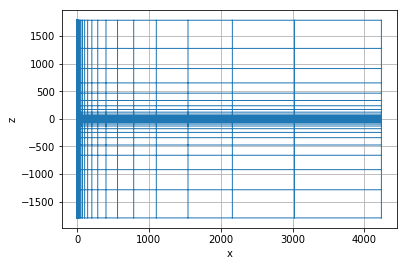

In [13]:
mesh_generator.mesh.plotGrid()

## Physical Properties

In [14]:
# Assign physical properties on the mesh
physpropsDict = {
    name: casingSim.model.PhysicalProperties(mesh_generator, mod) 
    for name, mod in model_dict.items()
}

### Condutivity

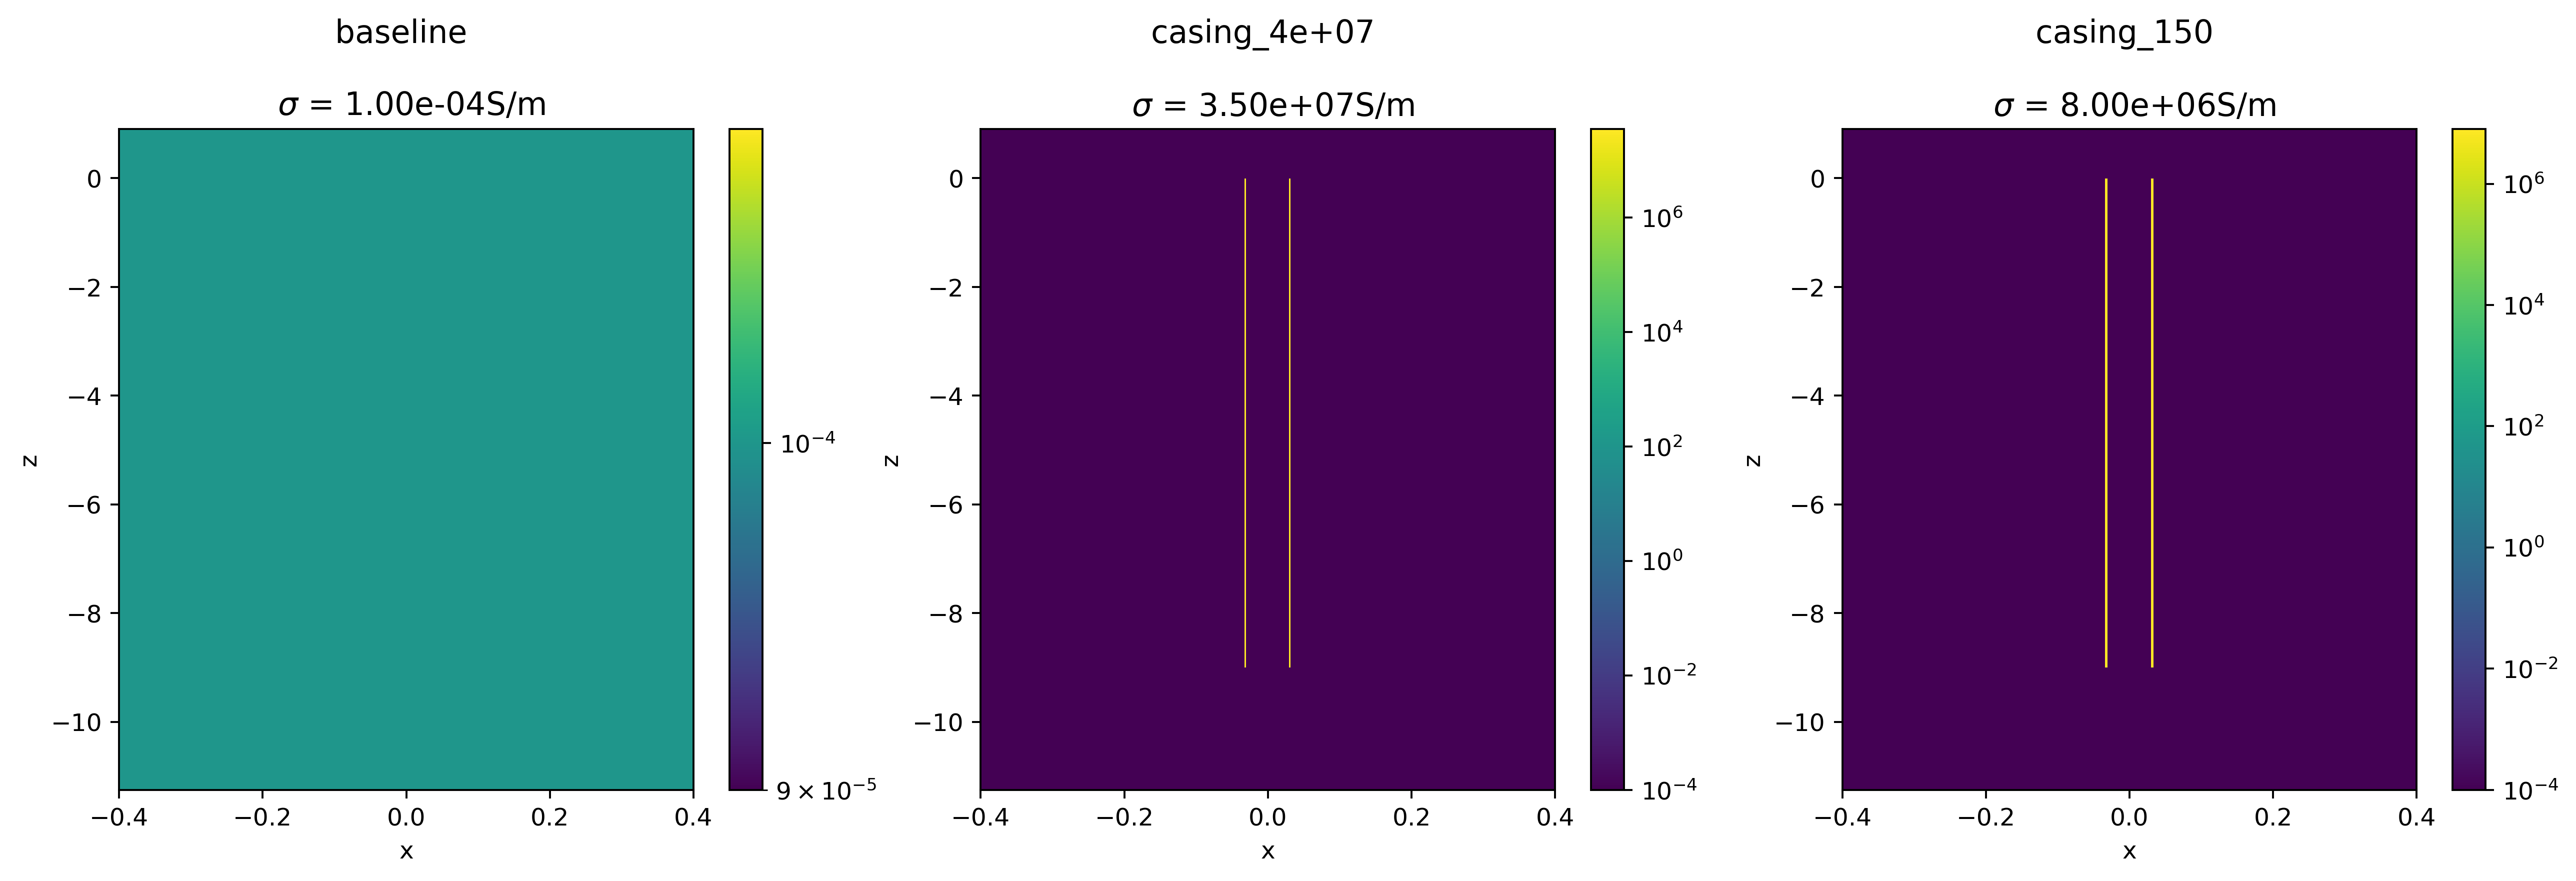

In [15]:
# Plot the models
xlim = 0.4*np.r_[-1, 1]  # x-limits in meters
zlim = np.r_[-1.25*casing_l, 0.1*casing_l]  # z-limits in meters. (z-positive up)

fig, ax = plt.subplots(1, len(model_names), figsize=(6*len(model_names), 5), dpi=350)
if len(model_names) == 1:
    ax = [ax]
    
for a, title in zip(ax, model_names):
    pp = physpropsDict[title]
    pp.plot_sigma(
        ax=a, 
        pcolorOpts={'norm':LogNorm()}  # plot on a log-scale
    )
    a.set_title('{} \n\n $\sigma$ = {:1.2e}S/m'.format(title, pp.modelParameters.sigma_casing), fontsize=13)
#     cylMeshGen.mesh.plotGrid(ax=a, slice='theta') # uncomment to plot the mesh on top of this
    a.set_xlim(xlim)
    a.set_ylim(zlim)

### Permeability

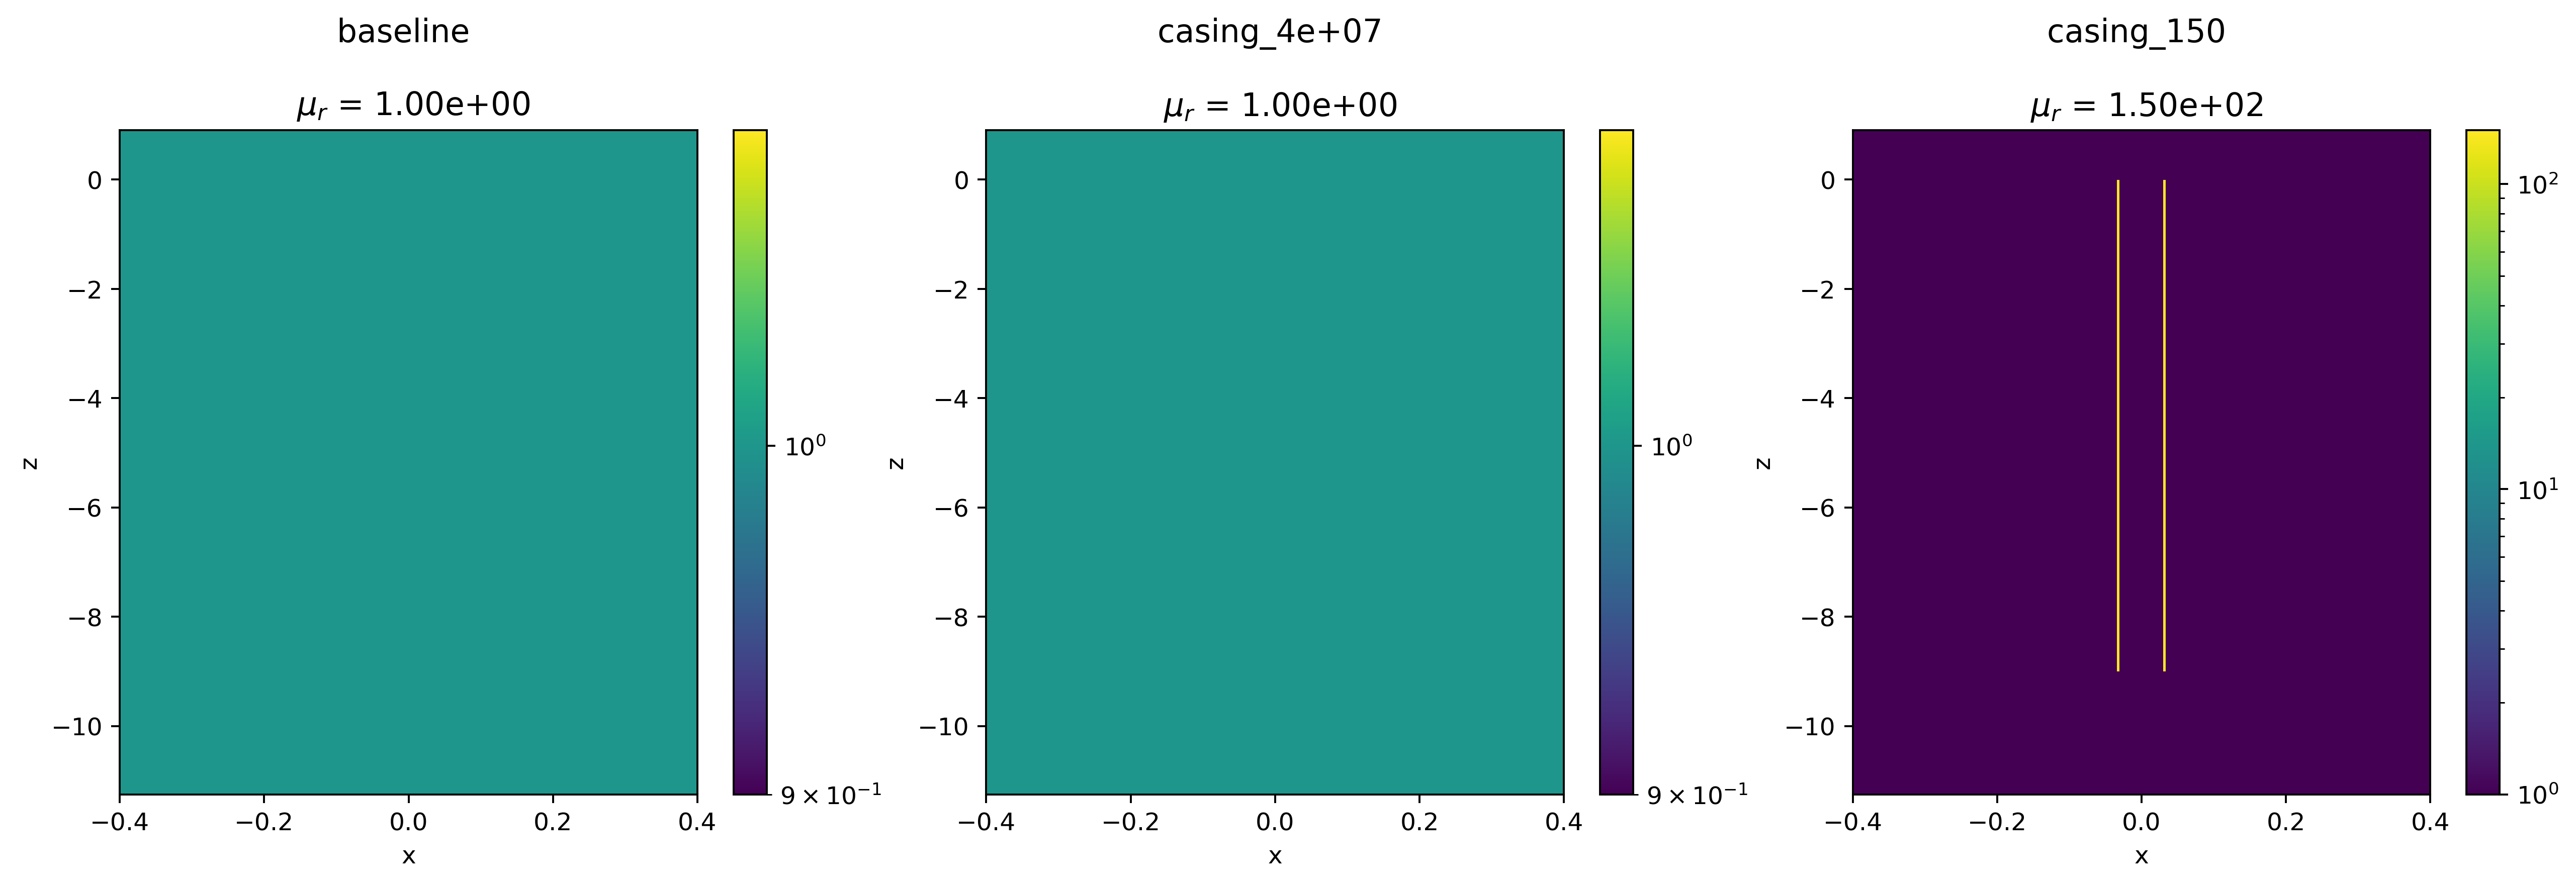

In [16]:
# Plot the models
xlim = 0.4*np.r_[-1, 1]  # x-limits in meters
zlim = np.r_[-1.25*casing_l, 0.1*casing_l]  #np.r_[-1.5*casing_l, 0.1*casing_l]  # z-limits in meters. (z-positive up)

fig, ax = plt.subplots(1, len(model_names), figsize=(6*len(model_names), 5), dpi=350)
if len(model_names) == 1:
    ax = [ax]
    
for a, title in zip(ax, model_names):
    pp = physpropsDict[title]
    pp.plot_mur(
        ax=a, 
        pcolorOpts={'norm':LogNorm()}  # plot on a log-scale
    )
    a.set_title('{} \n\n $\mu_r$ = {:1.2e}'.format(title, pp.modelParameters.mur_casing), fontsize=13)
#     mesh_generator.mesh.plotGrid(ax=a) # uncomment to plot the mesh on top of this
    a.set_xlim(xlim)
    a.set_ylim(zlim)

## Survey parameters

They run two scenarios
- `infinite pipe`: the source is positioned half way along the length of the pipe
- `semi-infinite pipe`: the source is positioned at the top of the pipe

Recievers are co-planar with the source (L=0.00m), and 1.49m below the source (L=1.49m). Additionally, we include a reciever 3cm below the source (L=0.03m)

In [17]:
z_half = -casing_l/2.

In [18]:
rx_locs1 = np.vstack([[0., 0., 0.], [0., 0., -0.03], [0., 0., -1.49]])
rx_locs2 = np.vstack([[0., 0., z_half], [0., 0., z_half-0.02], [0., 0., z_half-1.49]])

In [19]:
rx1_re = FDEM.Rx.Point_b(rx_locs1, orientation="z", component="real")
rx1_im = FDEM.Rx.Point_b(rx_locs1, orientation="z", component="imag")

rx2_re = FDEM.Rx.Point_b(rx_locs2, orientation="z", component="real")
rx2_im = FDEM.Rx.Point_b(rx_locs2, orientation="z", component="imag")

The radius of the loop is 0.6m. If you would like to investigate the impact of multiple source radii, uncomment the top line and comment out the second one. 

In [20]:
# loop_radius = [0.06, 0.3, 0.6, 3, 6]  # uncomment if you would like to examine more than one loop radius
loop_radius = [0.6]

In [21]:
src_list1 = []
src_list2 = []
    
src_list1 = [[FDEM.Src.CircularLoop(
    [rx1_re, rx1_im], f, np.r_[0., 0., 0.], orientation="z", current=1/(np.pi*r**2), radius=r
) for f in freqs] for r in loop_radius]

src_list2 = [[FDEM.Src.CircularLoop(
    [rx2_re, rx2_im], f, np.r_[0., 0., z_half], orientation="z", current=1/(np.pi*r**2), radius=r
) for f in freqs] for r in loop_radius]

src_list1_flat = [item for sublist in src_list1 for item in sublist]
src_list2_flat = [item for sublist in src_list2 for item in sublist]
src_list = src_list1_flat + src_list2_flat

## set up the simulation

In [22]:
wires = physpropsDict[model_names[0]].wires  # keeps track of which model parameters are sigma and which are mu
prob = FDEM.Problem3D_e(mesh=mesh_generator.mesh, sigmaMap=wires.sigma, muMap=wires.mu, Solver=Pardiso)

In [23]:
survey = FDEM.Survey(src_list)
prob.pair(survey)

## run the simulation

In [24]:
fields_dict = {}

In [25]:
%%time
for key in model_names:
    t = time.time()
    print('--- Running {} ---'.format(key))
    fields_dict[key] = prob.fields(physpropsDict[key].model)
    print(" ... done. Elapsed time {}\n".format(time.time() - t))

--- Running baseline ---
 ... done. Elapsed time 171.68428802490234

--- Running casing_4e+07 ---
 ... done. Elapsed time 157.0941550731659

--- Running casing_150 ---
 ... done. Elapsed time 184.85781407356262

CPU times: user 11min 20s, sys: 1min 53s, total: 13min 13s
Wall time: 8min 33s


## compute data from the fields

In [26]:
%%time
data_dict = {}
for key in model_names:
    model = physpropsDict[key].model
    prob.model = model
    data_dict[key] = Data(survey, survey.dpred(model, f=fields_dict[key]))

CPU times: user 4min 44s, sys: 1min 19s, total: 6min 4s
Wall time: 3min 46s


## compute the field strength ratio (FSR)

In [27]:
def get_fsr(model_key, srclist):
    """
    compute the field strength ratio, which is the ratio of the measured response 
    wrt a wholespace primary, given a model name source list
    """
    
    # baseline data
    baseline = np.array(
        [[data_dict['baseline'][src, rx] for rx in src.rxList] for src in srclist]
    )
    dat = np.array(
        [[data_dict[model_key][src, rx] for rx in src.rxList] for src in srclist] 
    )
        
    baseline_re = baseline[:, 0, :]
    baseline_im = baseline[:, 1, :]
    
    dat_re = dat[:, 0, :]
    dat_im = dat[:, 1, :]
    
    baseline_abs = np.sqrt(baseline_re**2 + baseline_im**2)
    dat_abs = np.sqrt(dat_re**2 + dat_im**2)
    
    fsr = dat_abs / baseline_abs
    
    return fsr

In [28]:
fsr_dict = {}

for key in model_names[1:]:
    fsr_dict[key] = {
        'semi-infinite': [get_fsr(key, src_list1[i]) for i in range(len(loop_radius))],
        'infinite': [get_fsr(key, src_list2[i]) for i in range(len(loop_radius))] 
    }

In [29]:
def plot_fsr(plt_models, plot_radii, plt_rx=range(rx_locs1.shape[1]), color_by='model', ax=None):
    
    if ax is None: 
        fig, ax = plt.subplots(len(plt_rx), 1, figsize=(6, 4*len(plt_rx)), dpi=300)

    if len(plt_rx) == 1:
        ax = [ax]
    
    for i, key in enumerate(plt_models):

        for ir, r in enumerate(plot_radii): 
            fsr_infinite = fsr_dict[key]['infinite'][r]
            fsr_semiinfinite = fsr_dict[key]['semi-infinite'][r]

#             label = "$\sigma$ = {:1.0e}, $\mu_r$ = {:1.0f}, r={:1.2f}".format(
#                 model_dict[key].sigma_casing, model_dict[key].mur_casing, plot_radii[ir], fontsize=10
#             )
            label = "{:s}".format("copper" if model_dict[key].sigma_casing in sigma_casing else "iron")

            for j, rx in enumerate(plt_rx):
                if color_by == 'model':
                    alpha=1-0.9*ir/float(len(plot_radii))
                    color=i
                else:
                    alpha=1
                    color=ir+2
                ax[j].semilogx(
                    freqs, fsr_infinite[:, rx], '-', color='C{}'.format(color), alpha=alpha, 
                    label="{} infinite {}".format(label, "r = {:1.2f}".format(loop_radius[r]) if len(plot_radii) > 1 else "")
                )
                ax[j].semilogx(
                    freqs, fsr_semiinfinite[:, rx], '--', color='C{}'.format(color), alpha=alpha,
                    label="{} semi-infinite".format(label)
                )
                ax[j].set_title('{} L = {:1.2f} m'.format(
                    "({})".format(string.ascii_lowercase[j]) if len(plt_rx) > 1 else "", np.abs(rx1_re.locs[rx, 2]))
                )

    for a in ax: 
        a.grid(which='both', alpha=0.4)
        a.legend(loc='lower left')
        a.set_xlabel('Frequency (Hz)')
        a.set_ylabel('FSR')
        a.set_xlim([freqs.min(), freqs.max()])
#         a.set_ylim([0., 1.75])
    
    plt.tight_layout()
    
    return ax

### Figure 8

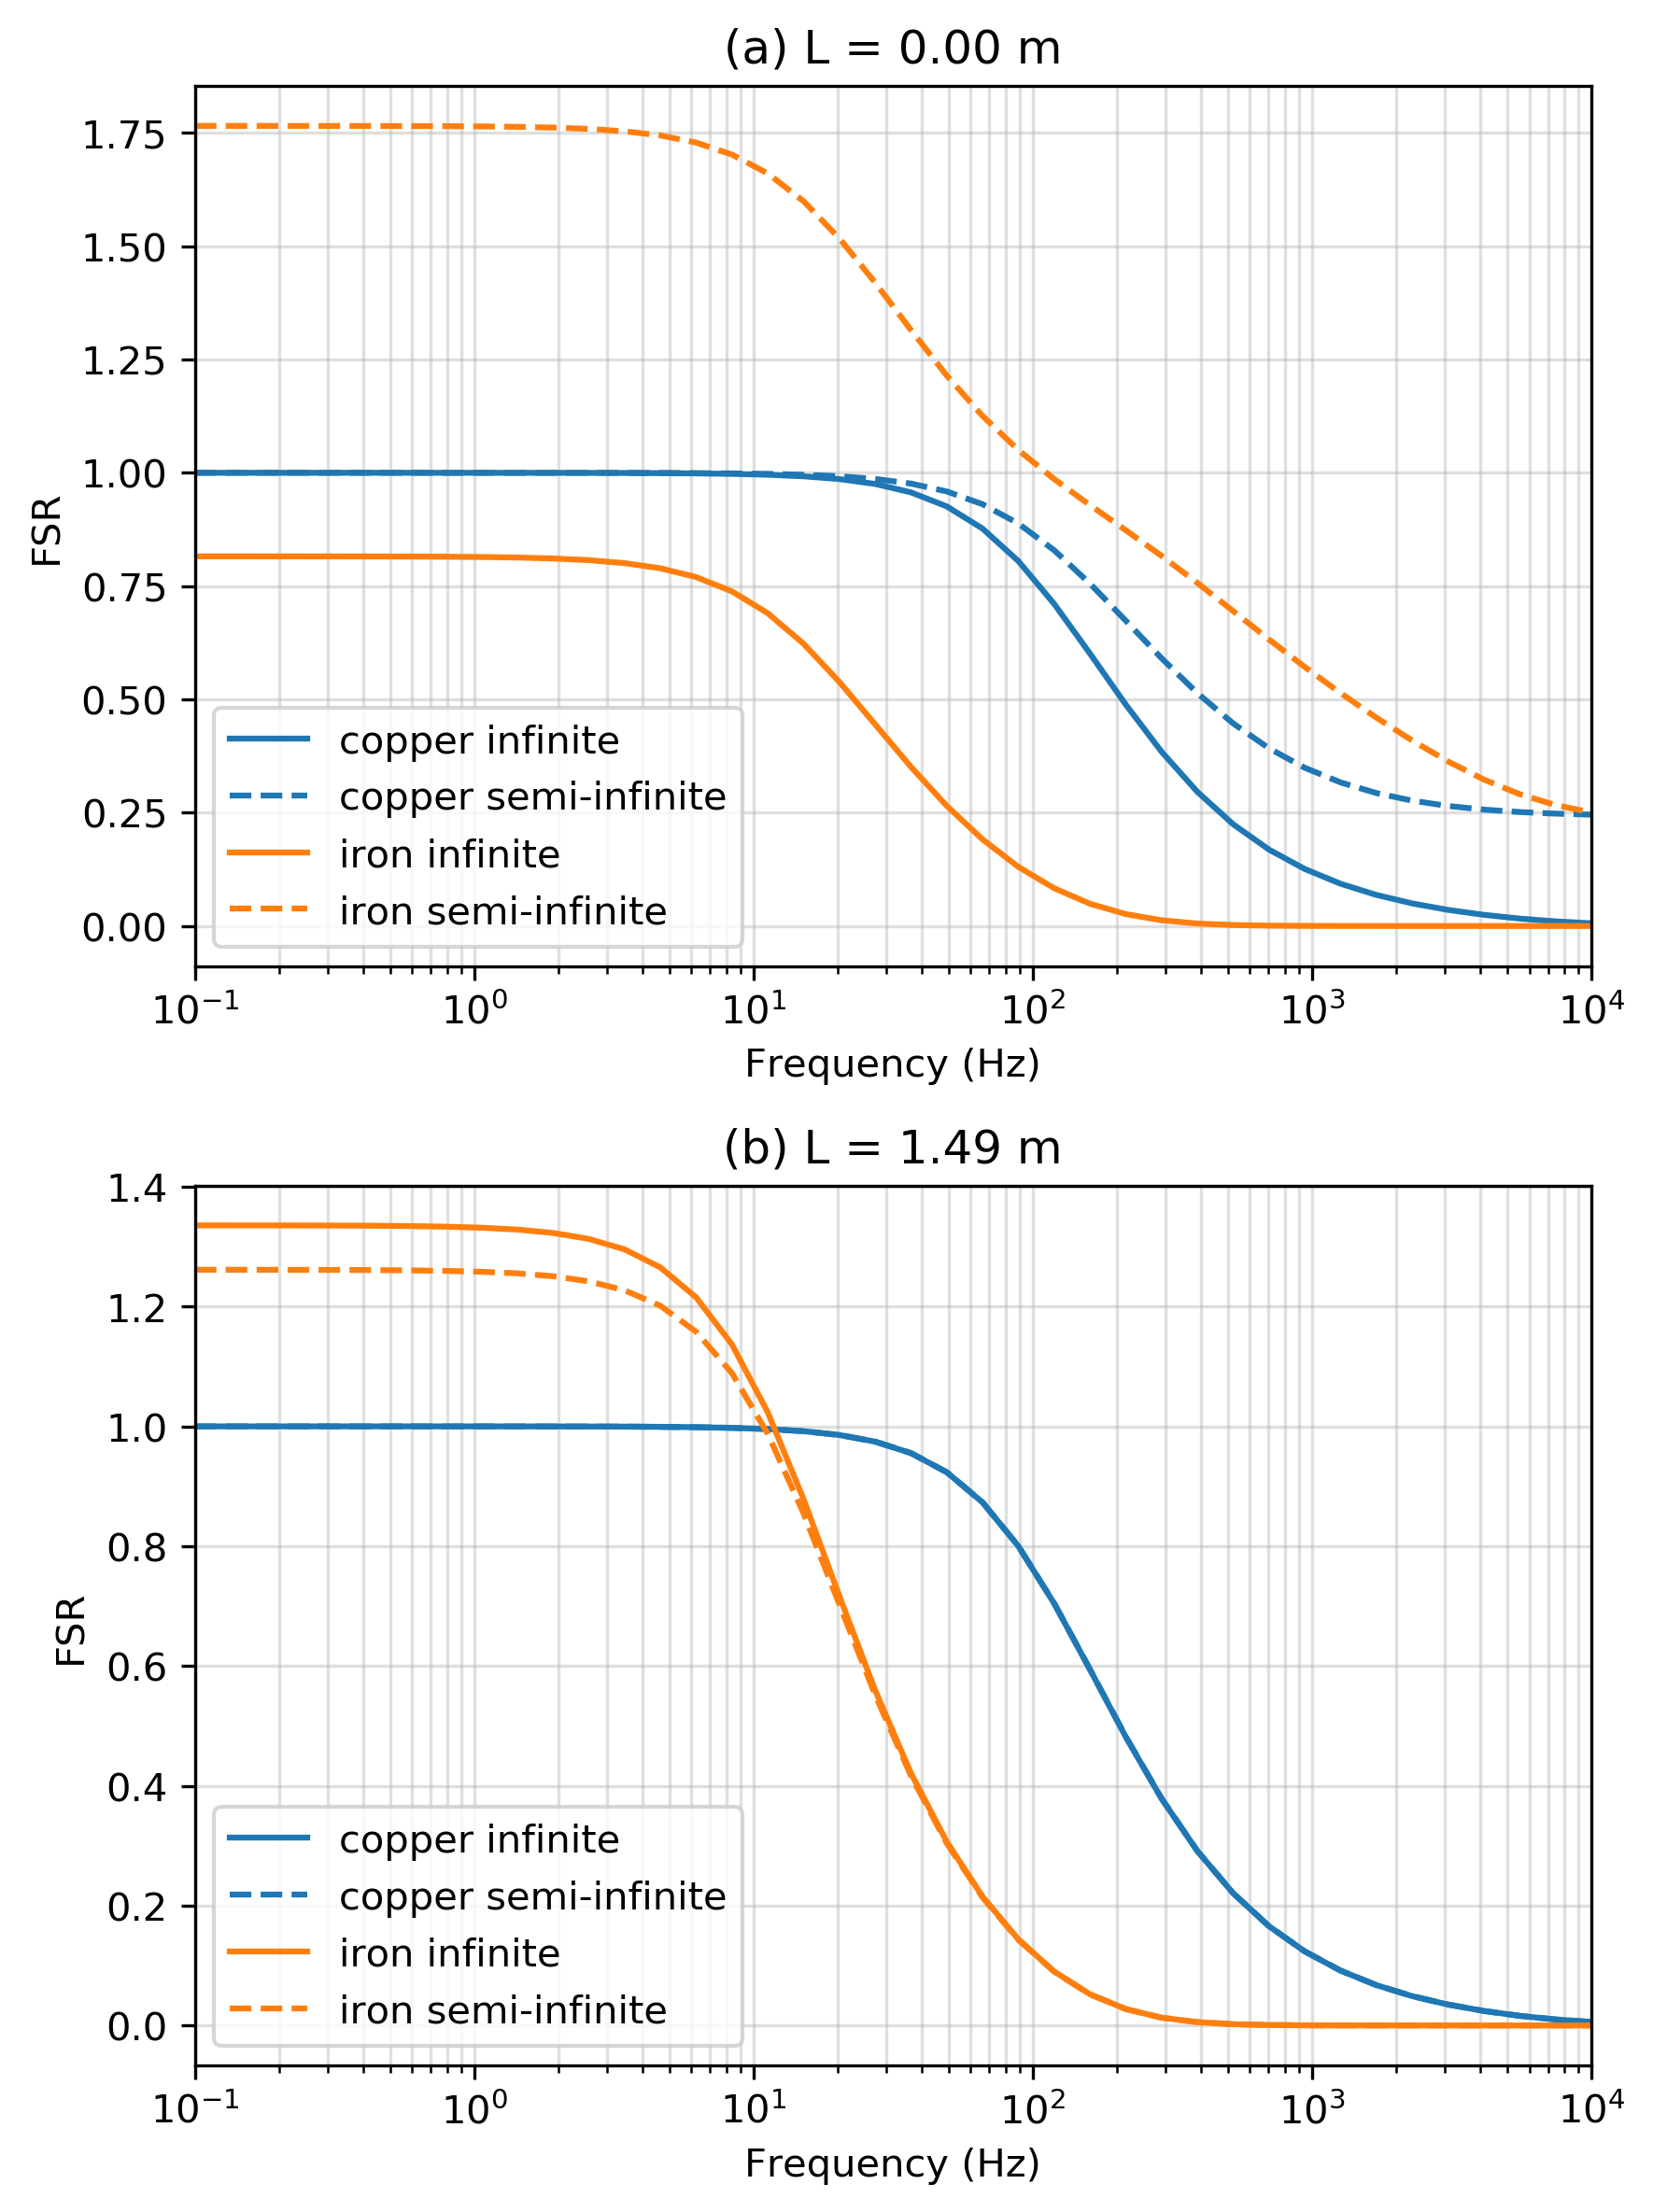

In [30]:
fig, ax = plt.subplots(2, 1, figsize=(6, 8), dpi=300)
plot_fsr(model_names[1:], [0], [0, 2], ax=ax)
fig.savefig('../figures/AugustinFSR')
fig.savefig('../arxiv-figures/AugustinFSR', dpi=200)

### Figure 10

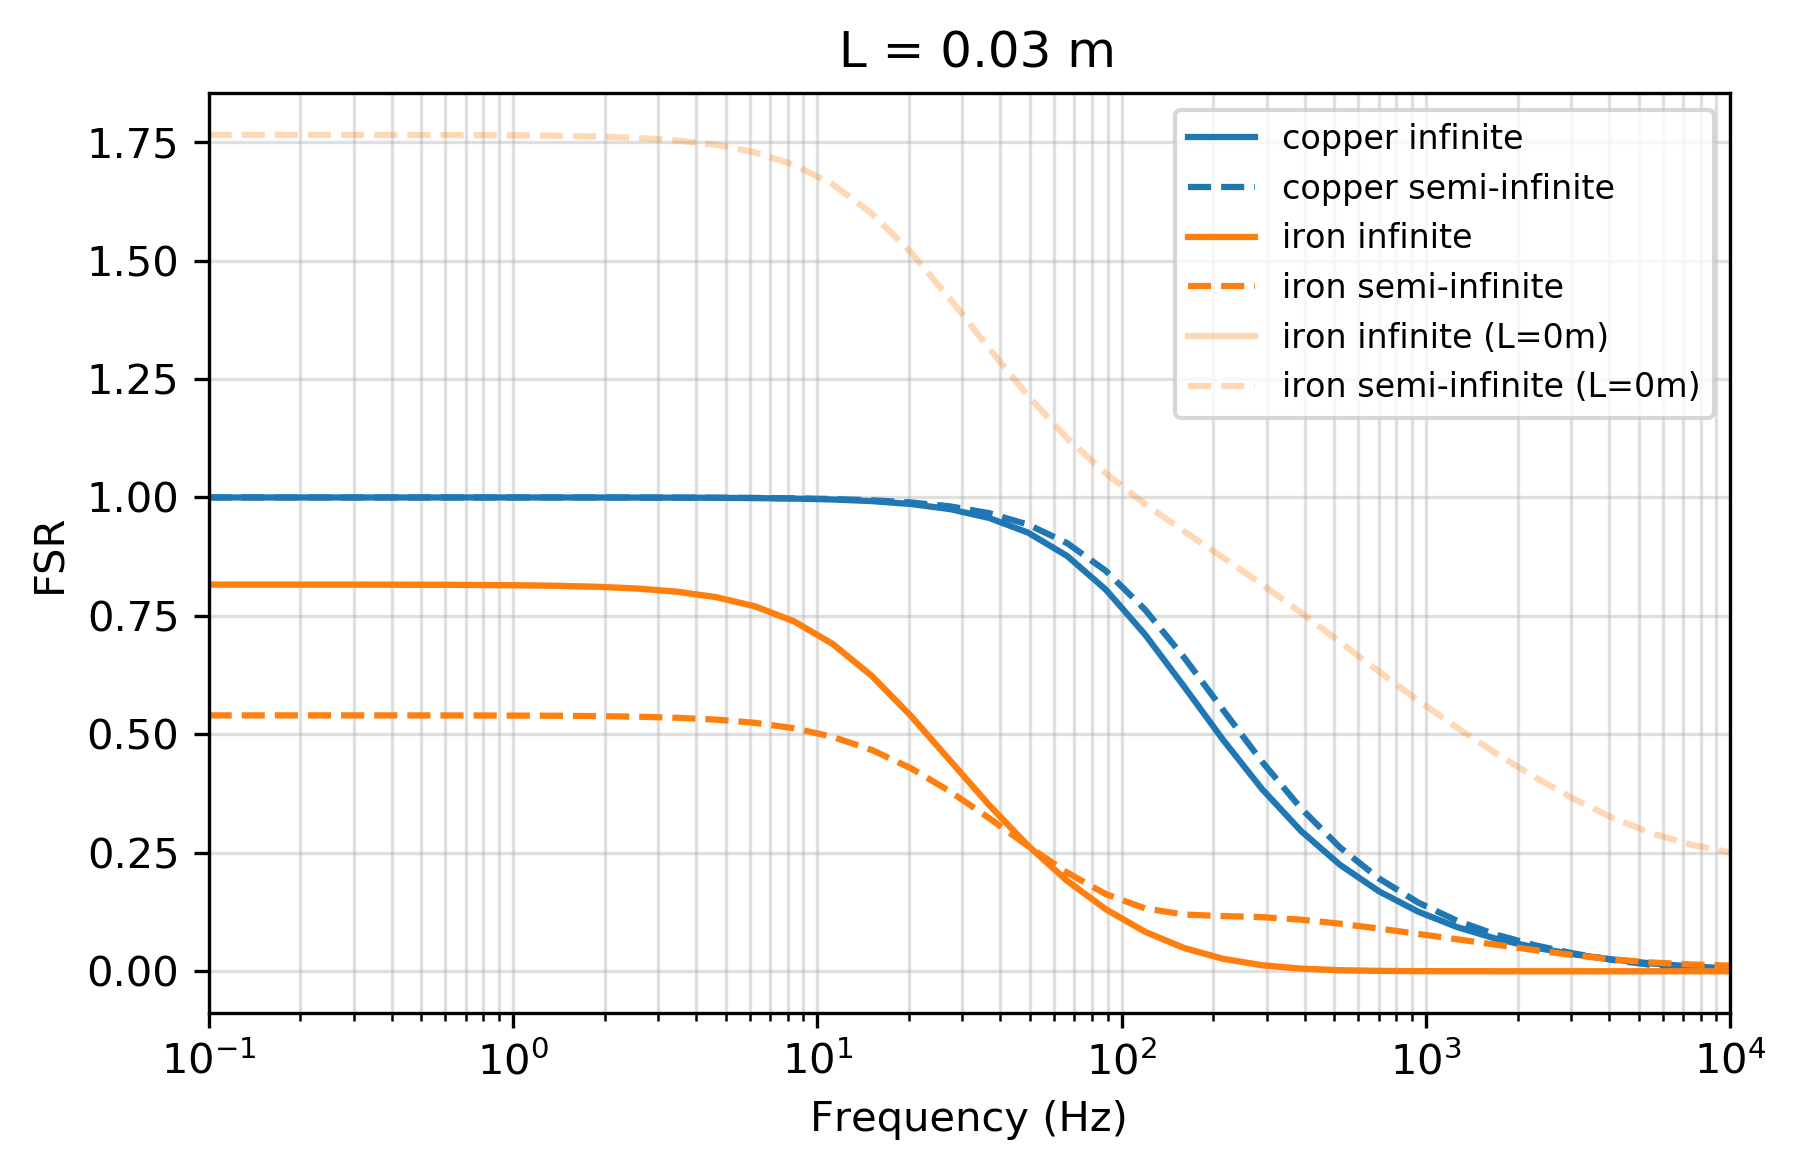

In [31]:
rcParams['font.size'] = 10
ax = plot_fsr(model_names[1:], [i for i in range(len(loop_radius)) if loop_radius[i] == 0.6], [1])

alpha = 0.3
rx = 0

key = 'casing_150'
r = 0
label = 'iron'
fsr_infinite = fsr_dict[key]['infinite'][r]
fsr_semiinfinite = fsr_dict[key]['semi-infinite'][r]
    
ax[0].semilogx(
        freqs, fsr_infinite[:, rx], '-', color='C1', alpha=alpha, 
        label="{} infinite (L=0m)".format(label)
    )
ax[0].semilogx(
    freqs, fsr_semiinfinite[:, rx], '--', color='C1', alpha=alpha,
    label="{} semi-infinite (L=0m)".format(label)
)

ax[0].legend(fontsize=8)

plt.savefig('../figures/Augustin3cm')
plt.savefig('../arxiv-figures/Augustin3cm', dpi=200)

## Visualize the charges, fields and fluxes

In [32]:
sim_dict = {}
for key in model_names:
    sim = casingSim.run.SimulationFDEM(
        directory=simDir, 
        meshGenerator=mesh_generator,
        modelParameters=model_dict[key],
        formulation=prob._solutionType[0],
#         srcList=survey.srcList
    )
    sim._prob = prob
    sim._survey = survey
    sim_dict[key] = sim

In [33]:
viewer = casingSim.FieldsViewer(
    sim_dict=sim_dict , fields_dict=fields_dict, 
    model_keys=model_names, primary_key='baseline'
)

In [34]:
viewer.widget_cross_section(fixed={'theta_ind':0})

interactive(children=(FloatText(value=0.064, description='max_r'), FloatText(value=-10.0, description='min_dep…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

In [35]:
# Plot the charges
# mesh2D = cylMeshGen.create_2D_mesh().mesh
mesh = mesh_generator.mesh
theta_ind=0
background_key = 'baseline'

def plotCasingResults(
    ax = None,
    clim_max=None, clim_min=None, 
    max_depth=1.1*model_dict[model_names[0]].casing_l, 
    max_r=0.1, top=10., view='charge', model='casing_100', 
    primsec='total', 
    casing_outline=True, 
    component='real',
    freq_ind=0, 
    loop_ind=[i for i in range(len(loop_radius)) if loop_radius[i] == 0.6],
    src_loc="semi-infinite",
    plot_mesh=False, 
    show_cb=True
):
    if ax is None: 
        plt.subplots(1, 1, figsize=(6, 7))
        
    assert view.lower() in ['j', 'e', 'b', 'h']

    xlim = max_r*np.r_[-1, 1]  # x-limits in meters
    zlim = np.r_[-max_depth, top]  # z-limits in meters. (z-positive up)
    
    clim = None
    plotopts = {
        'theta_ind': theta_ind,
#         'pcolorOpts':{'norm':LogNorm()}
        'pcolorOpts':{
            'norm':SymLogNorm(linthresh=3e-13),
        }
    }
    
    if not clim_max is not None or clim_max != 0.:
        clim = clim_max * np.r_[-1, 1]
        plotopts['clim'] = clim

        if clim_min is not None or clim_min != 0.:
            plotopts['clim'][0] = clim_min
        
    if primsec == 'primary':
        model = background_key

    pp = physpropsDict[model]
    
    if src_loc == "semi-infinite":
        src = src_list1[loop_ind][freq_ind]
    elif src_loc == "infinite":
        src = src_list2[loop_ind][freq_ind]
        
    plotme = fields_dict[model][src, view]
    
    if primsec == 'secondary':
#         if src_loc == "semi-infinite":
#             prim_src = src_list1[loop]
#         prim_src = survey.srcList[loop_ind][freq_ind]
        plotme = plotme - fields_dict[background_key][src, view]
    elif primsec == 'fsr':
        plotme = plotme / np.absolute(fields_dict[background_key][src, view])

    if view in ['j', 'e']:
        plotme = mesh.aveE2CC * plotme
        _, cb = pp.plot_prop(
            np.absolute(getattr(plotme, component)),
#             getattr(plotme, component),
#             logScale=False
            ax=ax,
            **plotopts 
        )
        
    elif view in ['b', 'h']:
        out = casingSim.plotFace2D(
            mesh,
            plotme, real_or_imag=component, ax=ax, range_x=xlim,
            range_y=zlim, sample_grid=np.r_[np.diff(xlim)/100., np.diff(zlim)/100.],
            log_scale=True, clim=clim, mirror=True, stream_threshold=clim_min if clim is not None else None, 
            show_cb=show_cb
        )
    ax.set_title('{} \n {} {} \n r = {:1.2f} m \n f={:1.2f}Hz'.format(
        model, view, component, loop_radius[loop_ind], freqs[freq_ind]), 
    )
    ax.set_xlim(xlim)
    ax.set_ylim(zlim)
#         cb.set_label(view)
#     cb.update_ticks()
        
    # plot outline of casing
    if casing_outline is True: 
        m = model_dict[model]
        factor = [-1, 1]
        [
            ax.plot(
                fact * np.r_[m.casing_a, m.casing_a, m.casing_b, m.casing_b, m.casing_a],
                np.r_[m.casing_z[1], m.casing_z[0], m.casing_z[0], m.casing_z[1], m.casing_z[1]],
                'k', 
                lw = 0.5
            ) 
            for fact in factor
        ]
    if plot_mesh:
        mesh.plotGrid(ax=ax)
    return out 
    

def plotCasingResultsWidget(
    clim_max=None, clim_min=None, 
    max_depth=1.1*model_dict[model_names[0]].casing_l, 
    max_r=0.1, top=10., view='charge', model='all', 
    primsec=['total', 'primary', 'secondary'],
    component='real',
    freq_ind=0,
    loop_ind=0,
    src_loc="semi-infinite",
    plot_mesh=False
):
    
    model_names = model_names if model == 'all' else [model]
    
    fig, ax = plt.subplots(1, len(model_names), figsize=(len(model_names)*5, 6))
    if len(model_names) == 1:
        ax = [ax]
    
    for a, mod in zip(ax, model_names): 
        a = plotCasingResults(
            ax = a,
            clim_max=clim_max, clim_min=clim_min, 
            max_depth=max_depth, 
            max_r=max_r, top=top, view=view, model=mod, 
            primsec=primsec, 
            casing_outline=True,
            component=component,
            freq_ind=freq_ind, 
            src_loc = src_loc,
            loop_ind=loop_ind,
            plot_mesh=plot_mesh
        )
    
    plt.tight_layout()
    plt.show()

In [36]:
# fig, ax = plt.subplots(1, 3, figsize=(18, 5), dpi=350)

ipywidgets.interact(
    plotCasingResultsWidget,
    clim_max = ipywidgets.FloatText(value=0),
    clim_min = ipywidgets.FloatText(value=0),
    max_depth = ipywidgets.FloatText(value=np.round(1.1*casing_l)), 
    max_r = ipywidgets.FloatText(value=0.09),
    top = ipywidgets.FloatText(value=0.1*casing_l),
    view = ipywidgets.ToggleButtons(
        options=['e', 'j', 'b', 'h'], value='b'
    ),
    model = ipywidgets.ToggleButtons(
        options=model_names, value=model_names[-1]
    ),
    primsec = ipywidgets.ToggleButtons(
        options=['total', 'primary', 'secondary', 'fsr'], value='total'
    ), 
    component=ipywidgets.ToggleButtons(
        options=['real', 'imag'], value="real"
    ), 
    freq_ind=ipywidgets.IntSlider(
        min=0, max=len(freqs)-1, value=0
    ),
    loop_ind=ipywidgets.IntSlider(
        min=0, max=len(loop_radius)-1, value=0,
    ),
    src_loc = ipywidgets.ToggleButtons(
        options=["infinite", "semi-infinite"], value="semi-infinite"
    ),
    plot_mesh = ipywidgets.Checkbox(value=False)
)   

interactive(children=(FloatText(value=0.0, description='clim_max'), FloatText(value=0.0, description='clim_min…

<function __main__.plotCasingResultsWidget(clim_max=None, clim_min=None, max_depth=9.9, max_r=0.1, top=10.0, view='charge', model='all', primsec=['total', 'primary', 'secondary'], component='real', freq_ind=0, loop_ind=0, src_loc='semi-infinite', plot_mesh=False)>

## Figure 9

In [37]:
from matplotlib import rcParams
rcParams['font.size'] = 16

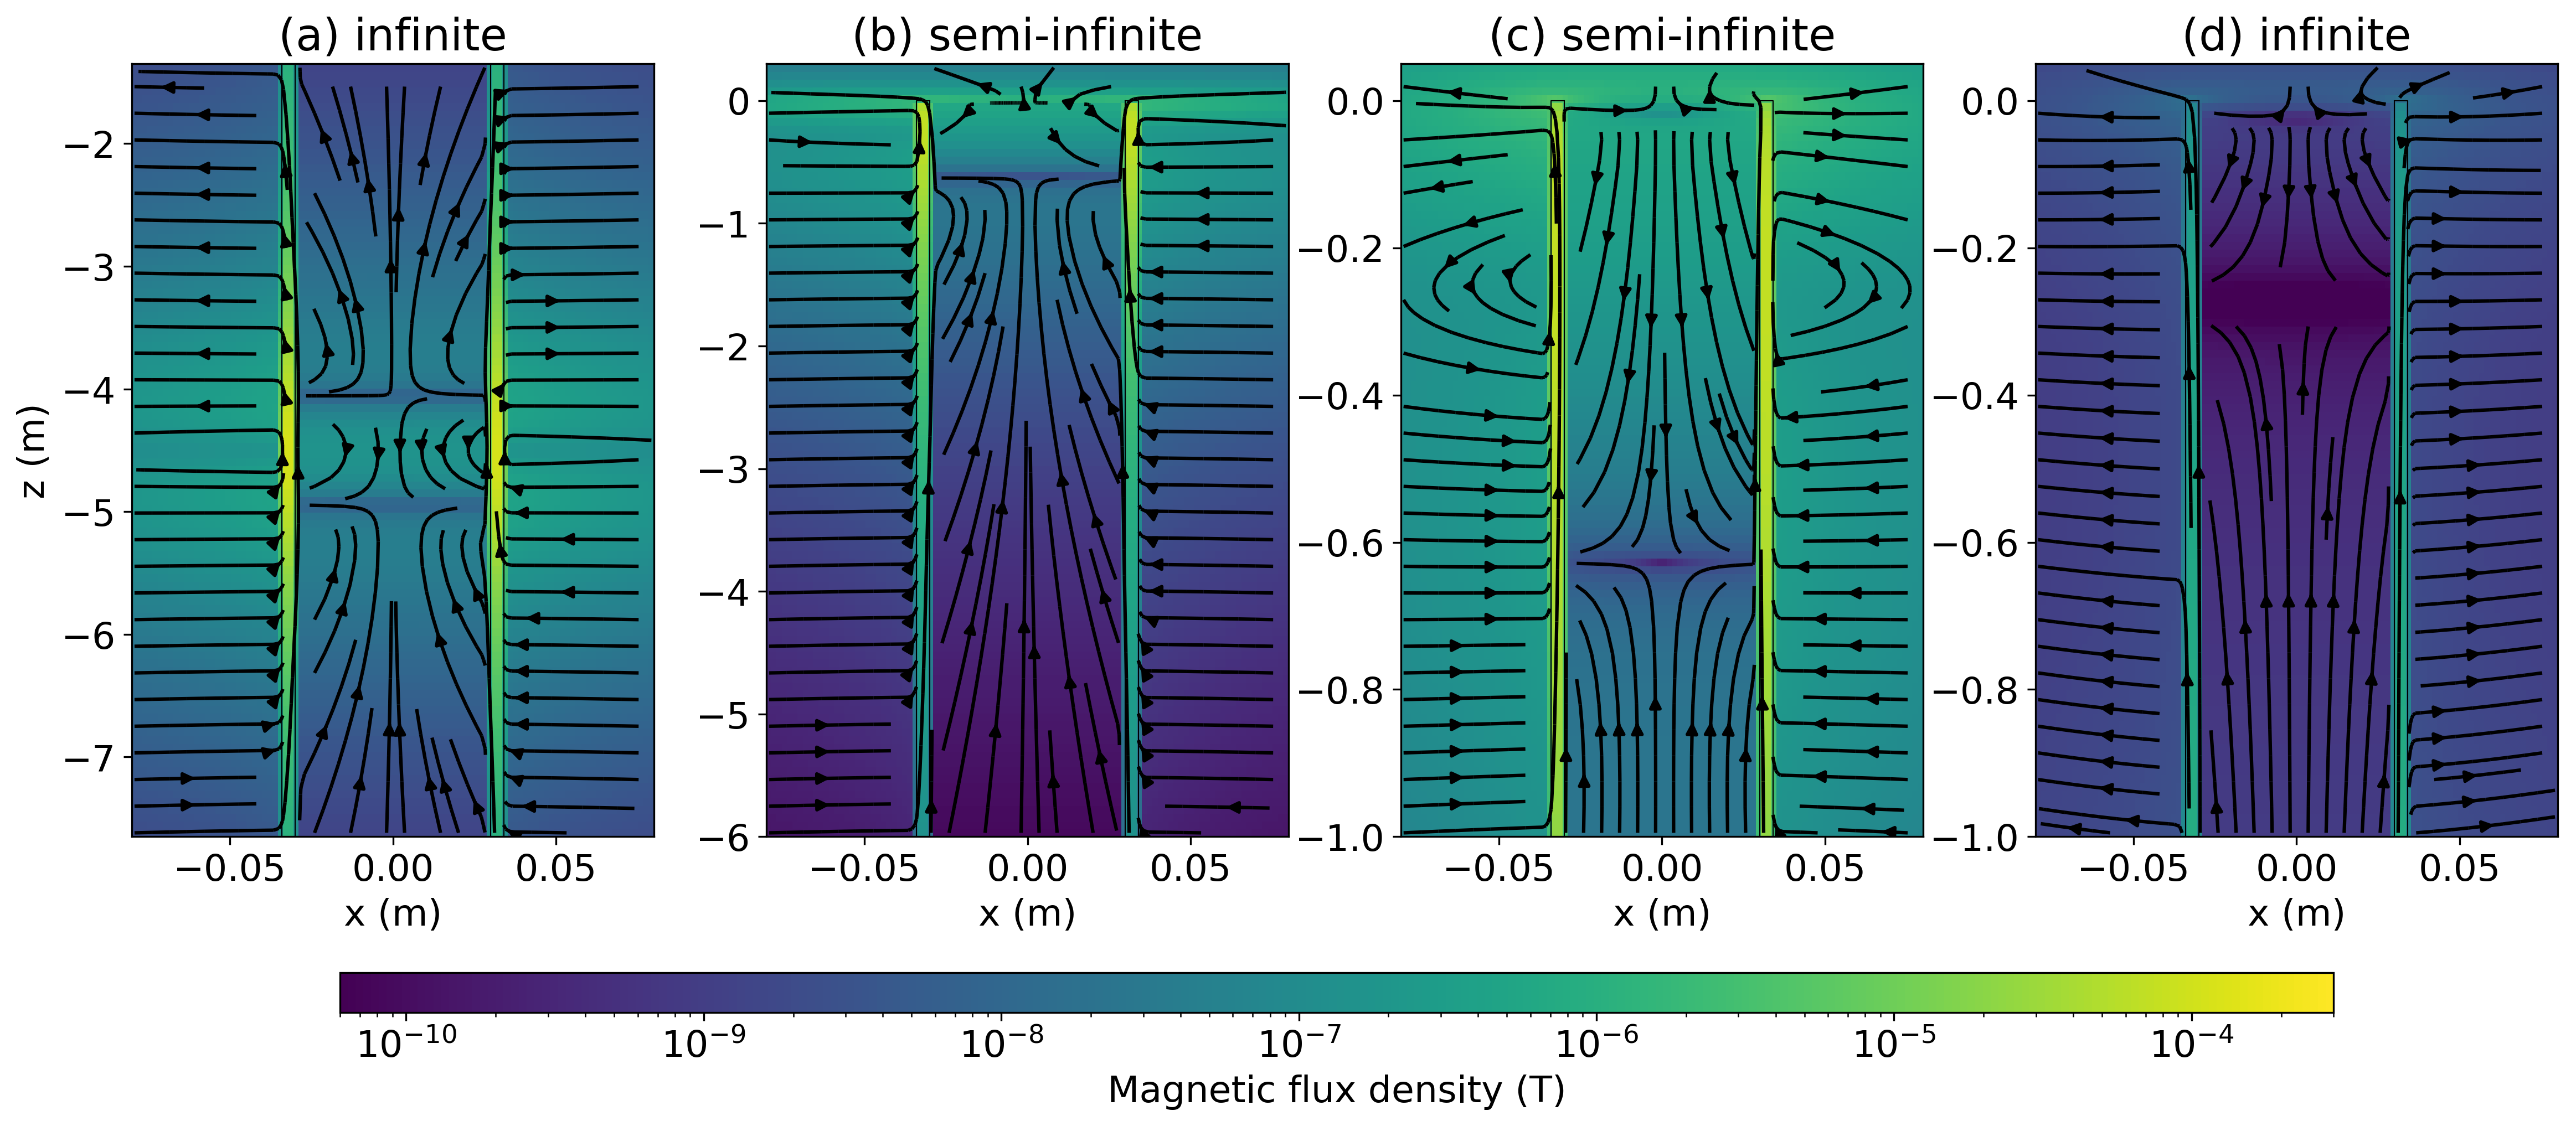

In [47]:
# fig, ax = plt.subplots(1, 3, figsize=(18, 5), dpi=350)

fig, ax = plt.subplots(1, 4, figsize=(4*4, 6), dpi=300)
ax=ax.flatten()
fig.subplots_adjust(bottom=0.8)
clim = [6e-11, 3e-4]

depths = np.r_[6, 1] #[10., 10., 1.6, 0.05]
tops = 0.05*depths

ranges = depths[0] + tops[0]

depths = np.hstack([[-z_half+ranges/2], depths, depths[-1]])
tops = np.hstack([z_half+ranges/2, tops, tops[-1]])

#['total', 'secondary', 'secondary', 'secondary']
model = 'casing_150'
loop_ind = 0
src_loc = ['infinite', 'semi-infinite', 'semi-infinite', 'infinite']

for i, a in enumerate(ax):
    out = plotCasingResults(
        ax=a,
        clim_max = clim[1],
        clim_min = clim[0],
        max_depth = depths[i], 
        max_r = 0.08,
        top = tops[i],
        view = 'b',
        model = model,
        primsec = "secondary", 
        component="real",
        freq_ind=0,
        loop_ind=loop_ind,
        src_loc = src_loc[i],
        plot_mesh = False, 
        show_cb=False
    ) 
    a.set_title("({}) {}".format(string.ascii_lowercase[i], src_loc[i]))
    a.set_xlabel("x (m)")
    a.set_ylabel("z (m)" if i ==0 else "")

cbar_ax = fig.add_axes([0.15, -0.04, 0.75, 0.04])
cb = fig.colorbar(out[0], cbar_ax, orientation='horizontal')
cb.set_label('Magnetic flux density (T)')

plt.tight_layout()

In [39]:
fig.savefig('../figures/AugustinBfields', bbox_inches="tight")
fig.savefig('../arxiv-figures/AugustinBfields', bbox_inches="tight", dpi=150)

## Check if we still see "edge effects" in the magneotstatic problem

To build confidence that the edge effects we are seeing are not a numerical artefact, we solve a different PDE and compare. Above, we solved the frequency domain EM problem, here we compare those results with the solution to the magnetostatic problem. In this case, we take a primary-secondary approach. 

$$
\nabla \times \vec{h} = \vec{j}_s\\
\nabla \cdot \vec{b} = \nabla \cdot{\mu}\vec{h} = 0
$$

where $\vec{j}_s$ is the source current density. Defining $\vec{h} = \vec{h}_p + \vec{h}_s$ and $\mu = \mu_p + \mu_s$ where $\vec{h}_p$ solves
$$
\nabla \times \vec{h_p} = \vec{j}_s \\
\nabla \cdot \mu_p \vec{h_p} = 0
$$
gives 
$$
\nabla \times \vec{h}_s = 0 \\
\nabla \cdot \mu \vec{h}_s = - \nabla \cdot \mu_s \vec{h}_p
$$

Since the gradient is in the null space of curl, we can define $\vec{h}_s = \nabla \phi$, giving

$$
\nabla \cdot \mu \nabla \phi= - \nabla \cdot \mu_s \vec{h}_p
$$

which is the system we solve below

In [40]:
src = src_list1[0][0]

# A magnetostatic
A_magnetostatic = prob.mesh.faceDiv * prob.MfMuiI * prob.mesh.faceDiv.T
Ainv = prob.Solver(A_magnetostatic)

# RHS magnetostatic
bp = prob.mesh.edgeCurl * src._srcFct(mesh.gridEy, 'cylindrical')[:, 1]
MfMuip = prob.mesh.getFaceInnerProduct(1./src.mu)
MfMuipI = prob.mesh.getFaceInnerProduct(
    1./src.mu, invMat=True
)
hp = MfMuip * bp

rhs = -prob.mesh.faceDiv * (
            (prob.MfMuiI - MfMuipI) * hp
        )


# b magnetostatic
phiSrc = Ainv * rhs
hs = prob.mesh.faceDiv.T * phiSrc
ht = hp + hs
b_magnetostatic = prob.MfMuiI * ht

In [41]:
np.linalg.norm(b_magnetostatic), np.linalg.norm(utils.mkvc(fields_dict['casing_150'][src, 'b']))

(0.0025579909422409988, 0.002557969659811001)

In [42]:
np.linalg.norm(utils.mkvc(fields_dict['casing_150'][src, 'b']) - b_magnetostatic)

1.1086266915857123e-05

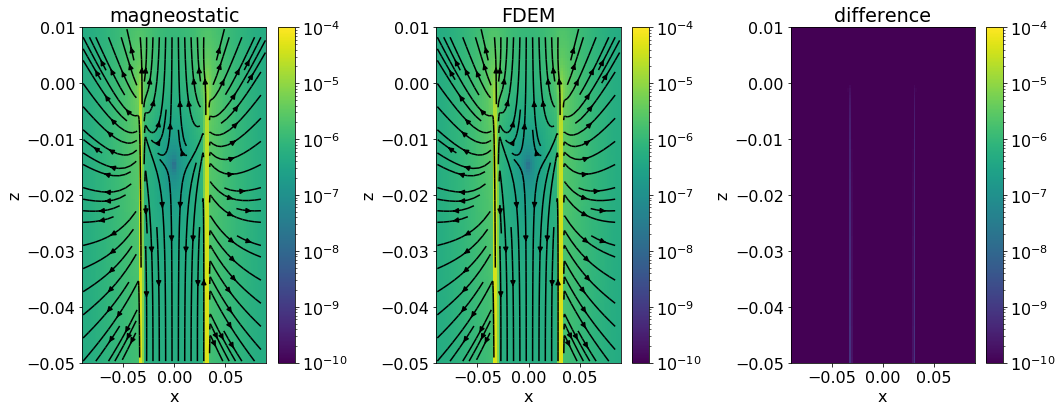

In [43]:
xlim = 0.09*np.r_[-1., 1.]
zlim = np.r_[-0.05, 0.01]
clim = [1e-10, 1e-4]

fig, ax = plt.subplots(1, 3, figsize=(3*5, 6))

casingSim.plotFace2D(
    mesh, 
    b_magnetostatic - bp, 
    ax=ax[0], real_or_imag='real', range_x=xlim,
    range_y=zlim, sample_grid=np.r_[np.diff(xlim)/100., np.diff(zlim)/100.],
    log_scale=True, clim=clim, mirror=True, stream_threshold=clim[0] if clim is not None else None
)
ax[0].set_title('magneostatic')

casingSim.plotFace2D(
    mesh, 
    utils.mkvc(fields_dict['casing_150'][src, 'b']) - utils.mkvc(fields_dict['baseline'][src, 'b']), 
    ax=ax[1], real_or_imag='real', range_x=xlim,
    range_y=zlim, sample_grid=np.r_[np.diff(xlim)/100., np.diff(zlim)/100.],
    log_scale=True, clim=clim, mirror=True, stream_threshold=clim[0] if clim is not None else None
)
ax[1].set_title('FDEM')


casingSim.plotFace2D(
    mesh, 
    (
        (utils.mkvc(fields_dict['casing_150'][src, 'b'])) -
        (b_magnetostatic)
    ), 
    ax=ax[2], real_or_imag='real', range_x=xlim,
    range_y=zlim, sample_grid=np.r_[np.diff(xlim)/100., np.diff(zlim)/100.],
    log_scale=True, clim=clim, mirror=True, stream_threshold=clim[0] if clim is not None else None
)
ax[2].set_title('difference')

plt.tight_layout()

In [44]:
versions('HTML')